One can use the next code cell to import modules

In [ ]:
!pip install loky

import numpy as np
import random as rdm
import math
import matplotlib.pyplot as plt
from itertools import repeat
from loky import get_reusable_executor

     |████████████████████████████████| 53 kB 1.3 MB/s 


  The next cell initializes a function to generate a board

In [ ]:
def Board_Maker(rows):
  board = []
  for i in range(rows):
    safe = rdm.getrandbits(1) ## A random number 0,1 decides which panel is safe to step on
    board.append(safe)
  return board                ## One does not need to generate a new random board to produce the correct mathematical result, but a random board allows for more experimentation

The next cell initializes a function to simulate a certain amount of players crossing a bridge of a certain amount of rows

In [ ]:
def Simulation(Players,rows):
  dead_counter = 0                  ## This variable is used to see how many people die ie. It tells us which players survive
  board = Board_Maker(rows)         ## We use the Board_Maker function from last cell to generate a board
  for i in range(Players):          ## For loop having each player attempt to cross the bridge
    alive = True                    ## Each player begins alive
    while alive == True:            ## This while loop keeps players crossing the bridge while they are alive
      if len(board) == 0:           
        break                       ## If there is no more space left on the board, that means the pattern is known and there is no need to guess randomly anymore
      step = rdm.getrandbits(1)     ## Step will be each players guess for every row of the board
      if step != board[0]:          ## If the player guesses incorrectly, they die, the loop ends, and the amount of dead people increases
        dead_counter += 1
        alive = False
      board.pop(0)                  ## After every turn we can remove the first row of the board because either someone correctly guessed it or the fell and the correct path is known
  return dead_counter

In [ ]:
def Monte_Carlo(tests,Players,rows):
  survivors = []                                     ## We will keep a list of who survives for every simulation
  for i in range(tests):                             ## This will simulate the amount of tests requested
    Deaths = Simulation(Players,rows)
    for j in range(Deaths+1,Players+1):              ## This range takes players from the first one after the last death until the last player and adds those numbers to the list of survivors
      survivors.append(j)
  survivor_percent = []                              ## Initialising list to count how many times each player survives
  for i in range(1,Players+1):                       ## This loop makes the aformentioned list
    survivor_percent.append((survivors.count(i)))
  survivor_percent = np.array(survivor_percent)      ## We turn the list into an numpy array
  survivor_percent = survivor_percent/tests          ## Now that it is a numpy array, we can easily divide the amount of times each player survived by the amount of tests to get each player's chance of survival
  return survivor_percent

print(Monte_Carlo(1000000,16,18))                 

[7.00000e-06 6.40000e-05 6.43000e-04 3.72200e-03 1.53960e-02 4.79660e-02
 1.19165e-01 2.40819e-01 4.07303e-01 5.92682e-01 7.59647e-01 8.80877e-01
 9.51279e-01 9.84305e-01 9.96288e-01 9.99367e-01]


This cell defines first the combination and the probability of each person in analytical way. Then it compares the analytical probabilities with the probability obtained with Monte Carlo with a graph of percentage errors against each contestants

In [ ]:
def nCr(n,r): #n=number of panels for combination, and r is the position of the person
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def P(p,n): # n = total number of panel, p = number of people
    total_prob = []
    ap = 1 #position of the person. So the first person to step on the board is number 1
    for i in range(p): # We are going to run n times, which is the number
        probability = 0 #The initial probability is zero
        for j in range(0,ap): #As we can see from the analytical formula for the probabilities, there is a sum of combination
          probability += nCr(n,j)
        final_probability = probability * (1/2)**18 # The sum of combination is hence multiplied by (1/2)^18
        total_prob.append(final_probability) # We append the probability to the list to obtain the numbers of the table with analytical probabilities
        
        ap += 1 # We continue with the next person
       
    return np.array(total_prob)

To see more clearly the errors against contestants, this cell provide the errors in log10.

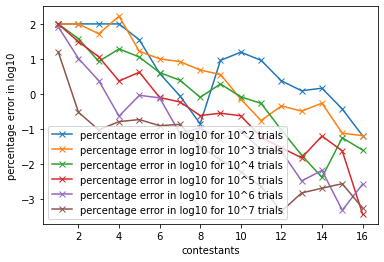

In [ ]:
for i in range(2, 8): # This is the percentage error graph but in log10, with which we can see more clearly the andament of the percentage error and how does it decrease as the number of trials increases
    percent_err = 100 * abs(abs(P(16, 18)) - abs(Monte_Carlo(10**i, 16, 18))) / P(16, 18)
    plt.plot(range(1, 17),
             np.log10(percent_err),
             marker='x',
             label='percentage error in log10 for 10^{0} trials'.format(i))
    plt.xlabel('contestants')
    plt.ylabel('percentage error in log10')

plt.legend()
plt.show()

This code plots error percentage against number of trials

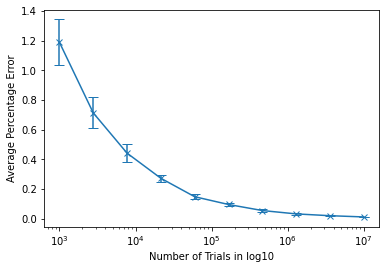

In [ ]:
def Find_error(input,Players,Rows):   #Takes in calculated values, Players and Rows
  abs_vals = P(Players, Rows)   #Calculates Absolute values from analytic task
  abs_err = np.zeros(shape=[len(input)])    #Array to hold the absolute error
  for i in range(0, Players):                   
    abs_err[i] = abs((input[i])-(abs_vals[i]))  
  perc_err = (sum(abs_err)/sum(abs_vals))*100   #perc_error calculated using the sum of each array
  return(perc_err)    
  
def find_average(input):    #Finds the mean of an array
  return((1/len(input) * sum(input)))   #returns 1/N * sum

def find_average_uncertainty(input):    #finds the uncertainty of the average 
  range = abs(np.amax(input - np.amin(input))) / 2  #(max-min)/2  = range
  return(range / math.sqrt(len(input)))   #range/sqrt(N)  = uncertainty of set

def Err_Monte_Carlo(input, Count, Players, Rows, _):   #Error from monte carlo, _ is null variable for iterating
  result = Find_error(Monte_Carlo(Count,Players,Rows),Players,Rows)
  return(result)   

def Error_Trials(Players, Rows):
  start_trial = 3   #10^(start_trial) = start trial count
  end_trial = 7   #10^(end_trial) = end trial count
  increments = 10   #Samples between start_trial and end_trial
  sample_count = 50   #Number of runs to calculate average from

  trial_counts = np.round(np.logspace(start_trial, end_trial, num=increments, endpoint=True, base=10.0))  #https://datascienceparichay.com/article/numpy-logspace/
  trial_counts = trial_counts.astype(int)   #converts floats to ints
  trial_results = np.zeros(shape=[len(trial_counts),sample_count])    #Will store the average error for each monte carlo run

  executor = get_reusable_executor()    #define loky reusable executor (multiprocessing)
  for i in range(0, len(trial_counts)):
    #Below: will initialise sample_count monte carlos to run in parallel
    result = list(executor.map(Err_Monte_Carlo, repeat(trial_counts[i]), repeat(Players), repeat(Rows), range(sample_count)))
    trial_results[i,:] = result #Stores results

  y_plots = np.zeros(shape=[len(trial_results)])    #defines y_plots
  y_err_plots = np.zeros(shape=[len(trial_results)])    #Error bar sizes

  for i in range(0, len(trial_results)):    #Fills the arrays with the average (& average error) of each trial
    y_plots[i] = find_average(trial_results[i,:])
    y_err_plots[i] = find_average_uncertainty(trial_results[i,:])

  plt.errorbar(trial_counts, y_plots,yerr = y_err_plots, marker = "x", capsize = 5)   #plots agraph of the results
  plt.xscale('log')
  plt.xlabel('Number of Trials in log10')
  plt.ylabel('Average Percentage Error')
  plt.show

Error_Trials(16, 18)

This last part defines a slightly modified Monte Carlo simulation to obtain the actual probabilities for each contestant to cross safely. Then plots the results against the number of steps and agains the number of players.


In [ ]:
def How_many_pass(tests,players,rows):
  n = np.array(tests*Monte_Carlo(tests,players,rows)) #Calls a slightly changed version of the original function in the way that it gives us a list of the actual amount of times each of the players survived (not the percentage)
  previous = 0 #This will be used later
  no_survivors = players 
  upper = 0 

  for i in n: #For every value of the list containing how often each player survived
    a = i - previous #This is important because it subtracts the amount of times the previous people survived from the amount of times this person survided. so this gives the amount of times this person was the FIRST to survive.
    previous = i 
    #Arithmetic mean or average is defined as frequency of event times event all of these summed and divided by sum of frequencies so this is the 'upper' part of the fraction --> see samjid Lecture 17
    upper = a*no_survivors + upper #So we multiply the amount of time e.g. 5 people have survived with 5 and so on.
    no_survivors = no_survivors - 1
  lower = tests
  average = upper/lower

  return average
print (How_many_pass(1000000, 16, 18))    
#note that due to small error derived from thee Monte Carlo simulation, the average varies slightly. 

7.004386


In [ ]:
no_pl_list = np.linspace(1,25,25, dtype = int)
board_lenght_list = np.linspace(1,25,25, dtype=int)

player_axis =[] #List that will have 25 times each value
averages_list = []
averages_percent_list = []
for i in no_pl_list:
  for j in board_lenght_list:
    av = How_many_pass(1000000,i,j)
    averages_list.append(av)  
    averages_percent_list.append(av/i)  

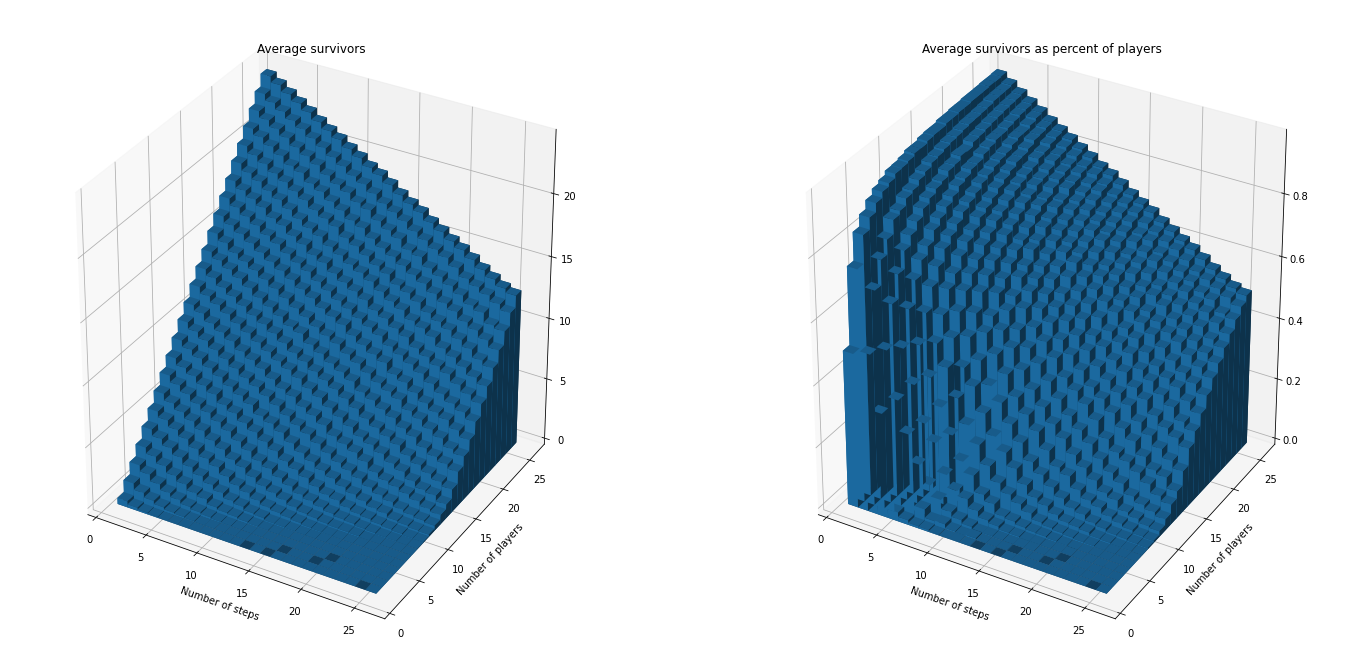

In [ ]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# arrays for players and steps
_x = np.arange(1,26,1)
_y = np.arange(1,26,1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z_values = (averages_list)
z_per_values = (averages_percent_list)
bottom = np.zeros_like(z_values)
width = depth = 1
ax1.bar3d(x, y, bottom, width, depth, z_values, shade=True)
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('Number of players')
ax1.set_title('Average survivors')
ax2.bar3d(x, y, bottom, width, depth, z_per_values, shade=True)
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Number of players')
ax2.set_title('Average survivors as percent of players')
plt.show()